## III. Feature selection, algorithm improvement

In this notebook, I shall run improve the best model from the preivous notebook (SVM Classificator) by undertaking the following steps:
    - Feature selection (Lasso)
    - Tune hyper paramters

Then I shall check and prove the improvement.


### 1 Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn import svm

from sklearn.metrics import roc_curve




%matplotlib inline
%matplotlib inline

### 2. Import datasets 

In [2]:
# Merge the two datasets
X_train=pd.read_csv('X_train.csv',sep= ',')
X_train.shape

(760, 20)

In [3]:
X_test=pd.read_csv('X_test.csv',sep= ',')
X_test.shape

(190, 20)

In [4]:
# Merge the two datasets
y_train=pd.read_csv('y_train.csv',sep= ',')
y_train.shape

(760, 1)

In [5]:
y_test=pd.read_csv('y_test.csv',sep= ',')
y_test.shape

(190, 1)

### 3. Model creation & data balancing 



#### 3.2 Smote for data imbalance

In [6]:
train_input = X_train
train_output = y_train


In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(train_input, train_output)
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({'CreditStatus': 1})
New dataset shape Counter({1: 414, 0: 414})


/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
train_input_new = X_train
train_ouput_new = y_train

Now both outcomes of the label are balanced

### 4. Feature selection (Filter methods plus lasso pipeline)

In [9]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((760, 19), (190, 19))

In [10]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

19

In [11]:
features_to_keep = X_train.columns[sel.get_support()]

In [12]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((760, 19), (190, 19))

In [13]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

In [14]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10


0

In [15]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((760, 19), (190, 19))

In [16]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

In [17]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  0


In [18]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((760, 19), (190, 19))

In [19]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

In [20]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

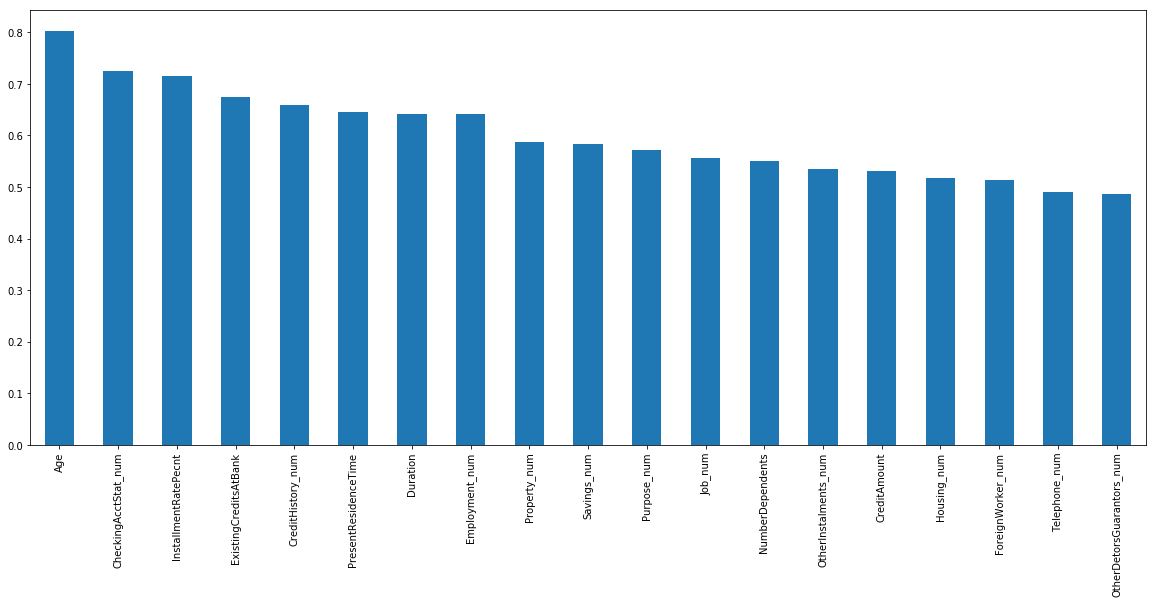

In [21]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [22]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features

selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(17, 19)

In [23]:
X_train.shape

(760, 19)

In [24]:
#Remove features using Lasso
# fit a lasso and selet features, make sure to select l1
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(X_train, y_train)

# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
X_train_lasso = pd.DataFrame(sel_.transform(X_train))
X_test_lasso = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_lasso.columns = X_train.columns[(sel_.get_support())]
X_test_lasso.columns = X_train.columns[(sel_.get_support())]

/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
X_train_lasso.shape, X_test_lasso.shape

((760, 18), (190, 18))

In [26]:
X_train = X_train_lasso
X_test = X_test_lasso

In [27]:
X_train.shape

(760, 18)

### 5. Tune mode hyperparamters

First we check the accuracy of the SVM classifier and verify we get the same result as before reducing the parameters

In [28]:
#remember becaus of the new data after imbalance adjustment, we use the following
#X_train, X_dev, Y_train, Y_dev = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

#importing module
from sklearn import svm
#making the instance
svc = svm.SVC(random_state=123)
#learning
svc.fit(X_train_lasso,y_train)
#Prediction
svcprediction=svc.predict(X_test_lasso)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy of SVM classifier:",metrics.accuracy_score(svcprediction,y_test))

SVM_accuracy = metrics.accuracy_score(svcprediction,y_test)



Accuracy of SVM classifier: 0.7842105263157895


/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Reducing the fature set from 20 to 18 we have the same accuracy. 

Now we try to improve it below

In [29]:
#With Hyper Parameters Tuning
#2-3,SVM
#importing modules
from sklearn.model_selection import GridSearchCV
from sklearn import svm
#making the instance
model=svm.SVC()
#Hyper Parameters Set
params = {'C': [6,7,8,9,10,11,12], 
          'kernel': ['linear','rbf']}
#Making models with hyper parameters sets
model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
#Learning
model1.fit(X_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
#Prediction
prediction=model1.predict(X_test)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("New improved Accuracy:",metrics.accuracy_score(prediction,y_test))

New_accuracy = metrics.accuracy_score(prediction,y_test)




/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyper Parameters:
 {'C': 6, 'kernel': 'rbf'}
New improved Accuracy: 0.7947368421052632


/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Check for improvement**

In [30]:
print (New_accuracy - SVM_accuracy)

0.010526315789473717


We have improved our model accuracy by 0.01 and reduced the featues space by 2!

**7.Save the model**

In [31]:
from sklearn.externals import joblib
from joblib import dump, load
dump(model1,'model1.joblib')  

/anaconda3/envs/featsel3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['model1.joblib']